<a href="https://colab.research.google.com/github/vishnudas-raveendran/PGP-AIML/blob/master/ComputerVision/Project2/CV_Project_2_PartA_Face_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CV Project 2

# Part 1: Face Detection in Images

In [1]:
%tensorflow_version 2.x
import tensorflow
print(tensorflow.__version__)
import numpy as np
from PIL import Image as im
import pandas as pd

2.8.0


## 1. Import the Dataset and perform EDA

In [2]:
face_dataset = np.load("/content/drive/MyDrive/GL Project Dataset/images.npy",allow_pickle=True)

### a. Basic Dataset Info

In [3]:
face_dataset.shape

(409, 2)

Dataset consists of 409 images and 2 columns

In [4]:
face_dataset[0][0]

array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8)

In [5]:
face_dataset[0][1]

[{'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
   {'x': 0.1723076923076923, 'y': 0.45345345345345345}]},
 {'imageHeight': 333,
  'imageWidth': 650,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
   {'x': 0.6584615384615384, 'y': 0.46846846846846846}]}]

The column 1 is numpy array of image data and column 2 contains the metadata of the image in JSON format. The metadata includes img attributes such as height, width, label, notes and bounding box coordinates of the label.

Column 2 is a list of JSONs depending on how many faces exists in the image. There is one bounding box per face.

The bounding boxes are in the format x0, y0, x1, y1 format and is scaled.


### b) Display sample images and draw a bounding box for a sample image

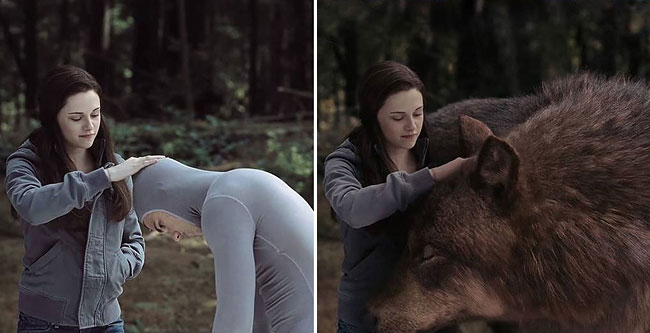

In [6]:
im.fromarray(face_dataset[0][0])

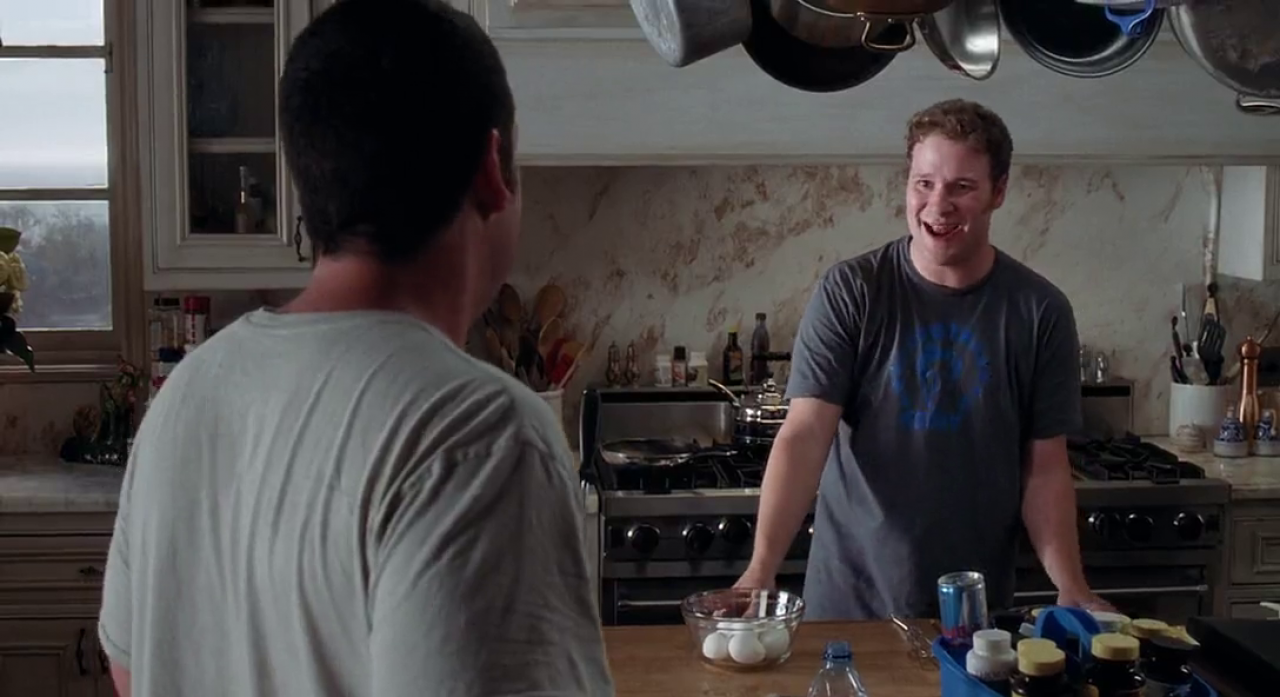

In [39]:
im.fromarray(face_dataset[1][0])

The images are not of uniform size

In [7]:
face_dataset[1][1]

[{'imageHeight': 697,
  'imageWidth': 1280,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.7053087757313109, 'y': 0.23260437375745527},
   {'x': 0.7692307692307693, 'y': 0.36182902584493043}]}]

In [8]:
def get_coordinates_from_dataset(metadata):
  x0= metadata["points"][0]['x']
  y0 = metadata["points"][0]['y']
  x1 = metadata["points"][1]['x']
  y1 = metadata["points"][1]['y']
  return x0,y0,x1,y1

In [9]:
def scale_coordinates(image_width, image_height, x0,y0, x1, y1):
  x0 = int(x0 * image_width) # Scale the BBox
  y0 = int(y0 * image_height)
  x1 = int(x1 * image_width)
  y1 = int(y1 * image_height)
  return x0, y0, x1, y1

In [10]:
x0, y0, x1, y1 = get_coordinates_from_dataset(face_dataset[1][1][0])

In [11]:
image = face_dataset[1][0]
image.shape
x0, y0, x1, y1 = scale_coordinates(image.shape[1], image.shape[0], x0,y0,x1,y1)

Rectangle(xy=(902, 162), width=82, height=90, angle=0)


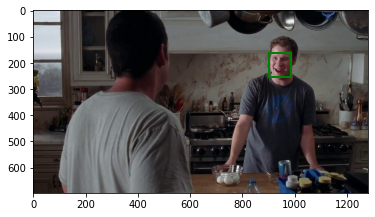

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(face_dataset[1][0])

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='g', facecolor='none')
print(rect)
# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

## 2. Create labels and features.

In [124]:
ALPHA = 1 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

OUT_IMG_WIDTH = 56
OUT_IMG_HEIGHT = 56


In [125]:
from cv2 import cvtColor, COLOR_BGRA2BGR, resize, INTER_NEAREST, imread
from tensorflow.keras.applications.mobilenet import preprocess_input

y = np.zeros((face_dataset.shape[0], OUT_IMG_HEIGHT, OUT_IMG_WIDTH))
X = np.zeros((face_dataset.shape[0], IMAGE_HEIGHT, IMAGE_WIDTH, 3))
print(X.shape)
for i in range(face_dataset.shape[0]):
  img = resize(face_dataset[i][0],(IMAGE_HEIGHT,IMAGE_WIDTH),interpolation = INTER_NEAREST)
  if len(img.shape) > 2 and img.shape[2] == 4:
    #convert the image from RGBA2RGB
    img = cvtColor(img, COLOR_BGRA2BGR)
  try:
    img = img[:, :, :3]
  except:
    continue
  X[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
  
  for masksi in face_dataset[i][1]:   #Processing all faces(coordinates) in the image
    x0, y0, x1, y1 = get_coordinates_from_dataset(masksi)  
    x0, y0, x1, y1 = scale_coordinates(OUT_IMG_WIDTH, OUT_IMG_WIDTH, x0,y0,x1,y1)
    y[i][y0:y1,x0:x1] = 1

(409, 224, 224, 3)


In [127]:
print(X.shape)
print(y.shape)

(409, 224, 224, 3)
(409, 56, 56)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


343


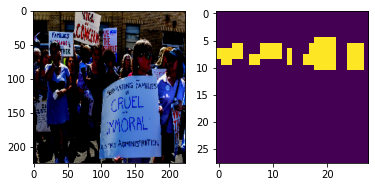

In [82]:
import random
n = random.choice(range(len(X)))
print(n)
plt.subplot(1,2,1)
plt.imshow(X[n])

plt.subplot(1, 2, 2)
plt.imshow(y[n])

plt.show()

In [126]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [128]:
print("Training size: "+str(y_train.shape[0])+"\n Testing size: "+str(y_test.shape[0]))

Training size: 274
 Testing size: 135


## 3. Train Model 

In [64]:
ALPHA = 1 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [129]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block2])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block1])
    print(x.shape)

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((OUT_IMG_HEIGHT, OUT_IMG_WIDTH))(x)
    print(x.shape)

    return Model(inputs=model.input, outputs=x)

In [86]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

In [87]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

In [130]:
model = create_model(True)
model.summary()

(None, 14, 14, 1536)
(None, 28, 28, 1792)
(None, 56, 56, 1920)
(None, 56, 56)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
              

In [132]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [133]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=5)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)

In [134]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=10, batch_size=32, verbose=1)

Epoch 1/10
9/9 [==============================] - 78s 8s/step - loss: 2.4954 - dice_coefficient: 0.2877 - val_loss: 1.2177 - val_dice_coefficient: 0.4407
Epoch 2/10
9/9 [==============================] - 67s 7s/step - loss: 1.5334 - dice_coefficient: 0.4386 - val_loss: 1.1698 - val_dice_coefficient: 0.4360
Epoch 3/10
9/9 [==============================] - 67s 7s/step - loss: 1.0096 - dice_coefficient: 0.5207 - val_loss: 1.8208 - val_dice_coefficient: 0.2654
Epoch 4/10
9/9 [==============================] - 67s 7s/step - loss: 0.7450 - dice_coefficient: 0.5923 - val_loss: 2.1275 - val_dice_coefficient: 0.2135
Epoch 5/10
9/9 [==============================] - 67s 7s/step - loss: 0.6233 - dice_coefficient: 0.6478 - val_loss: 1.7968 - val_dice_coefficient: 0.2839
Epoch 6/10
9/9 [==============================] - 67s 7s/step - loss: 0.5594 - dice_coefficient: 0.6783 - val_loss: 2.0178 - val_dice_coefficient: 0.2446
Epoch 7/10
9/9 [==============================] - 68s 8s/step - loss: 0.5113

In [135]:
score = model.evaluate(X_test, y_test) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

5/5 [==============================] - 6s 1s/step - loss: 1.4855 - dice_coefficient: 0.3730
Test loss: 1.485520362854004
Test accuracy: 0.37304526567459106


## 4. Predict using the model

(224, 224, 3)
(224, 224, 3)
(224, 224)


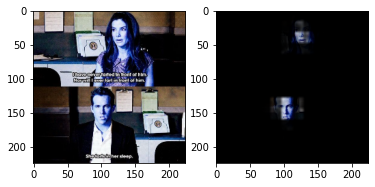

In [145]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
test_img = imread('part1-test.jpeg')
test_img = resize(test_img,(IMAGE_HEIGHT,IMAGE_WIDTH))
plt.subplot(1,2,1)
plt.imshow(test_img)
print(test_img.shape)
feat_scaled = preprocess_input(np.array(test_img, dtype=np.float32))

print(feat_scaled.shape)
pred_mask = resize(1.0*(model.predict(x=np.array([feat_scaled]))[0]), (IMAGE_WIDTH,IMAGE_HEIGHT))

print(pred_mask.shape)


image2 = test_img
image2[:,:,0] = pred_mask*test_img[:,:,0]
image2[:,:,1] = pred_mask*test_img[:,:,1]
image2[:,:,2] = pred_mask*test_img[:,:,2]

detected_faces = image2




plt.subplot(1, 2, 2)
plt.imshow(detected_faces)

plt.show()